In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
import lmfit as lm
%matplotlib widget

# Import data

In [226]:
genesis_block_date = np.datetime64('2009-01-03')
def date_to_daygen(date, genesis_block_date):
    return (pd.to_datetime(date)-genesis_block_date).days

# import historical data
btc_halving_dates=['2012-11-28','2016-07-09','2020-05-11','2024-04-19','2028-04-17'] # 2028 is predicted
btc_halving_daygen = np.array([date_to_daygen(h, genesis_block_date) for h in btc_halving_dates])
halving_mean_duration = np.diff(btc_halving_daygen).mean()

btc_history=pd.read_csv('bitcoin_2009-08-26_2024-09-25.csv')
btc_history.index=pd.to_datetime(btc_history.Start)
btc_history.index.rename('Date',inplace=True)
# add recent data
btc_price= yf.download("BTC-USD",start='2024-09-25', interval='1d')
btc_price

btc_price=pd.concat([btc_history,btc_price])
btc_price['DAY_GEN'] = btc_price.apply(lambda x:(x.name - genesis_block_date).days, axis=1)
btc_price.sort_index(inplace=True)

# find cycle tops
peak_cycle_idx=[]
for  d in range(len(btc_halving_dates)-2):
    start_cycle = btc_halving_dates[d]
    end_cycle = np.datetime64(btc_halving_dates[d])+np.timedelta64(1000,'D')
    btc_cycle_d=btc_price[(btc_price.index>start_cycle)&(btc_price.index<end_cycle)]
    peak_cycle_idx.append(btc_cycle_d.Close.idxmax())
btc_price

[*********************100%***********************]  1 of 1 completed


,Start,End,Open,High,Low,Close,Volume,Market Cap,Adj Close,DAY_GEN
Date,,,,,,,,,,
2010-07-17,2010-07-17,2010-07-18,0.050000,0.050000,0.050000,0.050000,0.000000e+00,170803.152488,NaN,560
2010-07-18,2010-07-18,2010-07-19,0.085800,0.085800,0.085800,0.085800,0.000000e+00,294746.595000,NaN,561
2010-07-19,2010-07-19,2010-07-20,0.080800,0.080800,0.080800,0.080800,0.000000e+00,277570.220000,NaN,562
2010-07-20,2010-07-20,2010-07-21,0.074700,0.074700,0.074700,0.074700,0.000000e+00,256710.178548,NaN,563
2010-07-21,2010-07-21,2010-07-22,0.079200,0.079200,0.079200,0.079200,0.000000e+00,274308.375000,NaN,564
...,...,...,...,...,...,...,...,...,...,...
2025-01-18,NaN,NaN,104124.953125,104913.203125,102226.617188,104408.070312,5.044566e+10,NaN,104408.070312,5859
2025-01-19,NaN,NaN,104411.289062,106299.796875,99570.531250,101089.609375,7.678993e+10,NaN,101089.609375,5860
2025-01-20,NaN,NaN,101083.750000,109114.882812,99471.359375,102016.664062,1.262797e+11,NaN,102016.664062,5861


/var/folders/hg/mp4c84nn0hd4q9_jjpxmjt041ykrjj/T/ipykernel_92897/406381033.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['End', 'Start'], dtype='object')
  btc_price_avg = btc_price.rolling(rolling_days).mean()


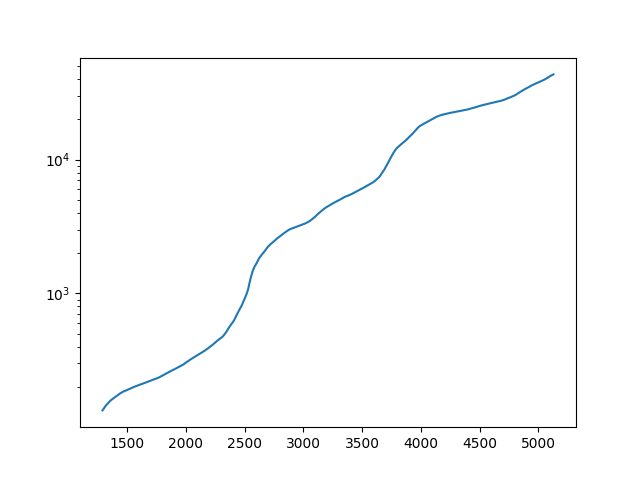

In [216]:
rolling_days = 4 * 365 # window of rolling average in days
btc_price_avg = btc_price.rolling(rolling_days).mean()

plt.figure()
plt.plot('DAY_GEN', 'Close', data=btc_price_avg)
plt.yscale('log')
plt.show()

# loglog fit

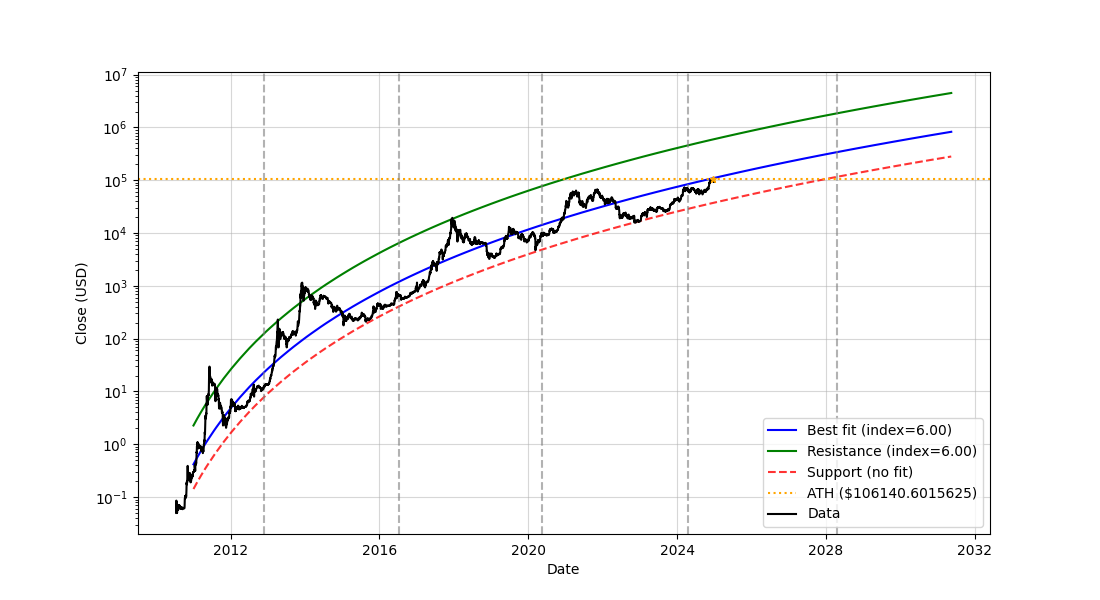

In [4]:
def pl_shift(x,A,alpha,x0):
    '''powerlaw with x normalized by the constant Enorm'''
    return A*(x/x0)**(alpha)

def fit_loglog(df, date_fit_start=None, date_fit_end=None, yaxis='Close', plot=1, model='linear'):
    if date_fit_start: df=df[df.index>date_fit_start]
    if date_fit_end: df=df[df.index<date_fit_end]
    x,y = np.log(df.DAY_GEN.values), np.log(df[yaxis])
    par = lm.Parameters()

    if model=='linear':
        par.add('intercept', value=-41.5)
        par.add('slope', value=6., min=0.,vary=0)
        # par.add('c', value=0., min=0.,max=10.,vary=0)
        gmodel = lm.models.LinearModel() # + lm.models.ConstantModel()

    # use initial model for support curve
    xplot=np.linspace(x.min(),x.max()+.4,100)
    #yinit = gmodel.eval(params=par, x=xplot)
    result = gmodel.fit(y, par, x=x)
    #print('current value ({}) is at the support of {}'.format())
    return result,xplot


yaxis='Close'
result_best,xplot =fit_loglog(btc_price,date_fit_start='2011-01-01',date_fit_end='2024-01-01', yaxis=yaxis ,plot=1,model='linear')
result_cycle_top, _= fit_loglog(btc_price.loc[peak_cycle_idx], yaxis='Close' ,plot=1,model='linear')
ath_idx=btc_price.Close.argmax()

dateplot = genesis_block_date + np.timedelta64(1,'D')*np.exp(xplot)

fig, ax=plt.subplots(figsize=(11,6))
ax.errorbar(x=btc_price.index, y=btc_price[yaxis], fmt='k', label='Data')
ax.plot(dateplot, np.exp(result_best.eval(x=xplot)),'blue',label='Best fit (index={:.2f})'.format(result_best.best_values['slope']))
ax.plot(dateplot, np.exp(result_cycle_top.eval(x=xplot)),'green',label='Resistance (index={:.2f})'.format(result_cycle_top.best_values['slope']))
ax.plot(dateplot, np.exp(-41.5 + 6 * xplot), '--',color='red',alpha=.8, label='Support (no fit)')
ax.axhline(btc_price.iloc[ath_idx].Close,color='orange',linestyle=':', label='ATH (${})'.format(btc_price.iloc[ath_idx].Close))
ax.plot(btc_price.iloc[ath_idx].name, btc_price.iloc[ath_idx].Close,'*', color='orange',markersize=5,zorder=10)
for halving_date in btc_halving_dates:
    ax.axvline(np.datetime64(halving_date),color='grey',linestyle='--',alpha=.6)
ax.set_xlabel('Date');ax.set_ylabel(yaxis+' (USD)')
ax.set_yscale('log')#;ax.set_xscale('log')
#ax.loglog()
ax.legend();ax.grid(alpha=.5)
plt.show()


# Direct Powerlaw fit

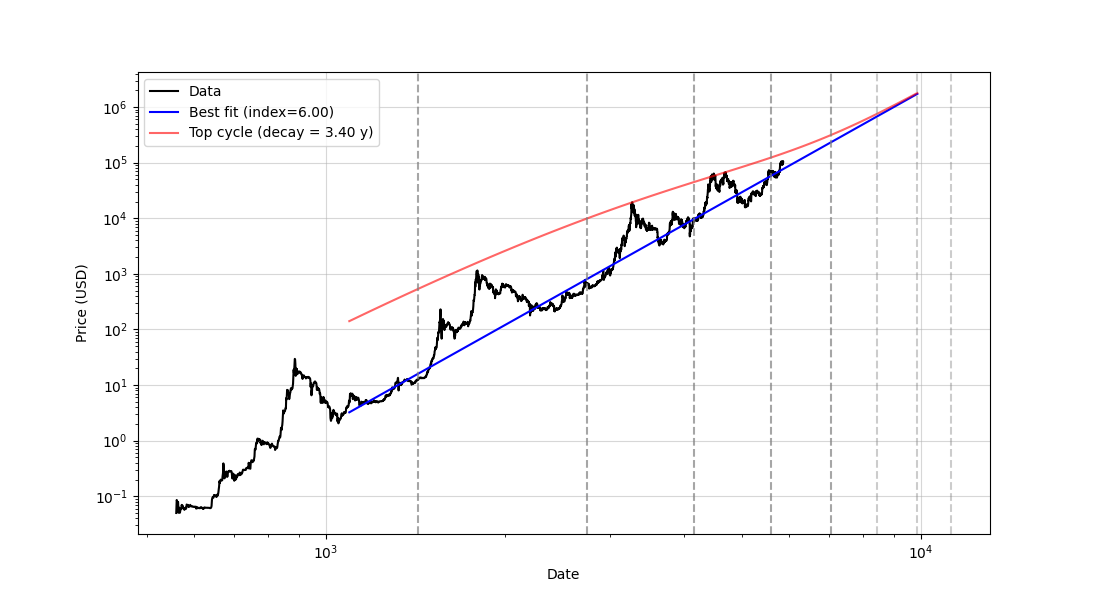

In [227]:
def exp_decay(x,B,tau):
    """ decaying exponential """
    return 1 + B * np.exp(-x/tau)

def fit_btc(df, date_fit_start=None, date_fit_end=None, yaxis='Close', model='linear',vary_plexp=1, day_extra=365):
    if date_fit_start: df=df[df.index>date_fit_start]
    if date_fit_end: df=df[df.index<date_fit_end]
    x,y = df.DAY_GEN.values, df[yaxis]
    par = lm.Parameters()

    if model=='powerlaw':
        par.add('amplitude', value=.1)
        par.add('exponent', value=6., min=4., max=8., vary=vary_plexp)
        gmodel = lm.models.PowerLawModel()

    xplot=np.linspace(x.min(),x.max()+day_extra,100)
    result = gmodel.fit(y, par, x=x)
    #print('current value ({}) is at the support of {}'.format())
    return result, xplot

def fit_peak(df, date_fit_start=None, date_fit_end=None, yaxis='Close', model='decay',vary_tau=1, pl_dico=None):
    if date_fit_start: df=df[df.index>date_fit_start]
    if date_fit_end: df=df[df.index<date_fit_end]
    x,y = df.DAY_GEN.values, df[yaxis]
    par = lm.Parameters()

    if model=='decay':
        i=1
        tau_estim = 4*365 #(df.DAY_GEN[i+1] -  df.DAY_GEN[i]) / np.log( df.cycle_ratio[i]/df.cycle_ratio[i+1])
        B_estim = df.cycle_ratio[i]/np.exp(-df.DAY_GEN[i]/tau_estim)
        par.add('amplitude', value=pl_dico['amplitude'],vary=0)
        par.add('exponent', value=pl_dico['exponent'], min=0.,vary=0)
        par.add('B', value=B_estim)
        par.add('tau', value = tau_estim, vary=vary_tau)
        gmodel = lm.models.PowerLawModel() * lm.Model(exp_decay)
    result = gmodel.fit(y, par, x=x)
    return result

day_extra = 12 * 365 # number of days to extrapolate model
loglogplot=1
vary_plexp, vary_tau = 0,1
yaxis='Close'

result_best, xplot =fit_btc(btc_price, '2012-01-01', '2024-01-01', yaxis, 'powerlaw', vary_plexp, day_extra)
# fit top cycles
btc_peak = btc_price.loc[peak_cycle_idx]
btc_peak['cycle_ratio'] = btc_peak.Close/result_best.eval(x=btc_peak.DAY_GEN) - 1
result_peak =fit_peak(btc_peak, None, None, yaxis, 'decay', vary_tau, result_best.best_values)

ath_idx=btc_price.Close.argmax()
dateplot = genesis_block_date + np.timedelta64(1,'D') * xplot
predicted_halving_daygen =  np.array([(k+len(btc_halving_daygen)+1)*halving_mean_duration for k in range(int(day_extra//halving_mean_duration))])
btc_all_halving = np.concatenate([btc_halving_daygen, predicted_halving_daygen])

fig, ax=plt.subplots(figsize=(11,6))
if loglogplot:
    ax.plot(btc_price.DAY_GEN, btc_price[yaxis], 'k', label='Data')
    ax.plot(xplot, result_best.eval(x=xplot),'blue', label='Best fit (index={:.2f})'.format(result_best.best_values['exponent']))
    ax.plot(xplot, result_peak.eval(x=xplot),'r',alpha=.6, label='Top cycle (decay = {:.2f} y)'.format(result_peak.best_values['tau']/365))
    for halving_date in btc_halving_daygen: ax.axvline(halving_date,color='grey',linestyle='--',alpha=.7)
    for halving_date in predicted_halving_daygen: ax.axvline(halving_date ,color='grey',linestyle='--',alpha=.4) # , label='Predicted halving'
    ax.set_xscale('log')
else:
    ax.plot(btc_price.index, btc_price[yaxis], 'k', label='Data')
    ax.plot(dateplot, result_best.eval(x=xplot),'blue', label='Best fit (index={:.2f})'.format(result_best.best_values['exponent']))
    ax.plot(dateplot, result_peak.eval(x=xplot),'r',alpha=.6, label='Top cycle (decay = {:.2f} y)'.format(result_peak.best_values['tau']/365))
    for halving_date in btc_halving_dates: ax.axvline(np.datetime64(halving_date),color='grey',linestyle='--',alpha=.6)

ax.set_yscale('log')
ax.set_xlabel('Date');ax.set_ylabel('Price (USD)')
ax.legend();ax.grid(alpha=.5)
plt.show()

In [165]:
cycle_period = 4*365
mu_peak = print(np.exp(-result_peak.best_values['tau']/cycle_period))
mu = 1/2
print(-cycle_period * np.log(mu))

0.4271405991148751
1011.9948836175201


# cycle ratio fit

## decaying periodic Lorentz fit

In [228]:
def find_cycle_k(x, btc_halving_daygen):
    '''find number of halving cycles that passed before date'''
    halving_diff = (x.DAY_GEN - btc_halving_daygen) # distance of date with each halving start
    valid_idx = np.where(halving_diff >= 0)[0] # select only positive distance
    return valid_idx[halving_diff[valid_idx].argmin()] # find index of smallest positive difference from halving event

# cycle ratio is defined as c = price/support - 1, where support is a PL
btc_price['cycle_ratio'] = btc_price[yaxis].values/result_best.eval(x=btc_price.DAY_GEN.values) - 1 #result_best.eval(x=btc_price.DAY_GEN.values)/btc_price[yaxis].values

start_cycle_fit, end_cycle_fit = '2013-01-01', '2024-01-01' # remove first cycle
rolling_days = 10 # window of rolling average in days
btc_cycle_fit = btc_price.loc[(btc_price.index>start_cycle_fit)&(btc_price.index<end_cycle_fit)].rolling(rolling_days, center=True).mean() # remove pre-first-halving data, smooth out details
btc_cycle_fit = btc_cycle_fit.dropna(subset=['cycle_ratio']) # remove resulting nans

btc_cycle_fit['k_cycle'] = btc_cycle_fit.apply(find_cycle_k, axis=1, args=[btc_halving_daygen])
btc_cycle_fit['DAY_CYCLE'] = btc_cycle_fit.DAY_GEN - btc_halving_daygen[btc_cycle_fit.k_cycle] # number of days after latest halving (t')
btc_cycle_fit

/var/folders/hg/mp4c84nn0hd4q9_jjpxmjt041ykrjj/T/ipykernel_92897/3799079777.py:12: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['End', 'Start'], dtype='object')
  btc_cycle_fit = btc_price.loc[(btc_price.index>start_cycle_fit)&(btc_price.index<end_cycle_fit)].rolling(rolling_days, center=True).mean() # remove pre-first-halving data, smooth out details


,Open,High,Low,Close,Volume,Market Cap,Adj Close,DAY_GEN,cycle_ratio,k_cycle,DAY_CYCLE
Date,,,,,,,,,,,
2013-01-07,13.64493,13.64493,13.64493,13.64493,0.000000e+00,1.450355e+08,NaN,1464.5,-0.267293,0,39.5
2013-01-08,13.74063,13.74063,13.74063,13.74063,0.000000e+00,1.461127e+08,NaN,1465.5,-0.265183,0,40.5
2013-01-09,13.81244,13.81244,13.81244,13.81244,0.000000e+00,1.469192e+08,NaN,1466.5,-0.264355,0,41.5
2013-01-10,13.89244,13.89244,13.89244,13.89244,0.000000e+00,1.478104e+08,NaN,1467.5,-0.263123,0,42.5
2013-01-11,13.97344,13.97344,13.97344,13.97344,0.000000e+00,1.487228e+08,NaN,1468.5,-0.261830,0,43.5
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-23,43054.34200,43770.42500,42430.06300,43267.36200,3.289910e+10,8.437649e+11,NaN,5466.5,-0.140860,2,1320.5
2023-12-24,43260.40500,43871.93100,42596.16700,43259.96200,3.311357e+10,8.467822e+11,NaN,5467.5,-0.141936,2,1321.5
2023-12-25,43251.00100,43843.83600,42579.82100,43235.68700,3.262436e+10,8.462277e+11,NaN,5468.5,-0.143334,2,1322.5


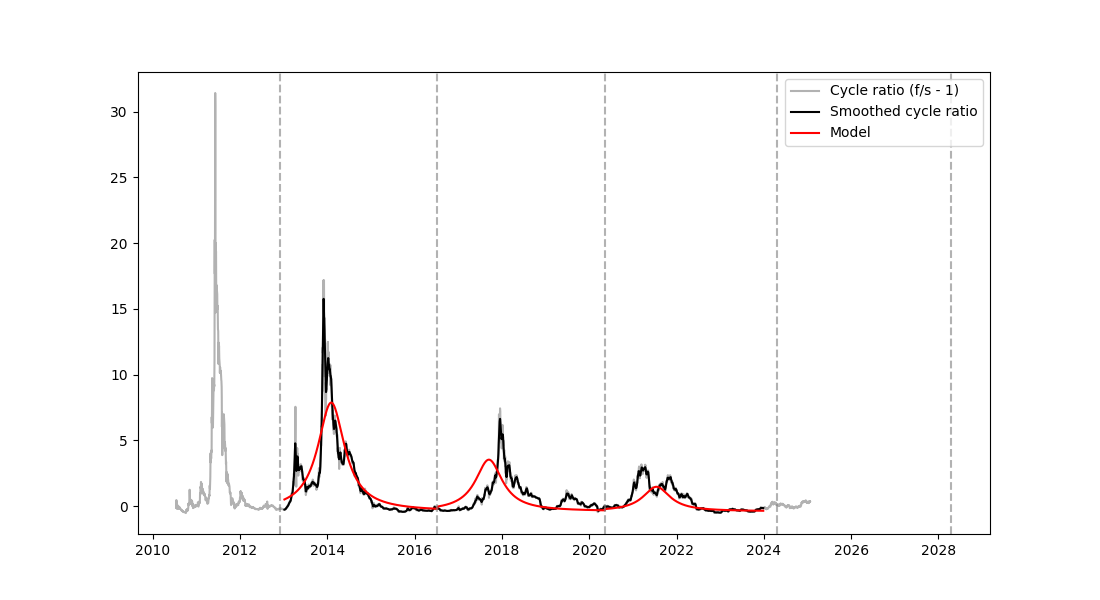

In [229]:
def decay_lorentz(x, A0, mu, sigma_c, d, PL_offset):
    ''' lorentzian with amplitude that decays exponentially through each k cycle + constant 
    x[0]=t: time in days, x[1]=k: cycle index
    A0: initial cycle amplitude, mu: decay ratio
    sigma_c: Lorentzian width = duration of bullrun, d: Lorentzian center = time from halving to peak in days
    PL_offset: offset from the base model (powerlaw)
    '''
    return ((A0 * mu**x[1])/np.pi) * (sigma_c / ((x[0] - d)**2 + sigma_c**2) ) + PL_offset

par_cycle= lm.Parameters()
par_cycle.add('A0', value=10, min=0)
par_cycle.add('mu', value=mu_peak, min=0, vary=1)
par_cycle.add('sigma_c', value=300, min=0)
par_cycle.add('d', value=300, min=0)
par_cycle.add('PL_offset', value=-.4, vary=0)
gmodel = lm.Model(decay_lorentz)

result_cycle = gmodel.fit(btc_cycle_fit.cycle_ratio, par_cycle, x=[btc_cycle_fit.DAY_CYCLE, btc_cycle_fit.k_cycle] )
display(result_cycle)

fig, ax=plt.subplots(figsize=(11,6))
ax.plot(btc_price.index, 'cycle_ratio',color='grey',alpha=.6, label='Cycle ratio (f/s - 1)', data=btc_price)
ax.plot(btc_cycle_fit.index, 'cycle_ratio','k', label='Smoothed cycle ratio', data=btc_cycle_fit)
ax.plot(btc_cycle_fit.index, result_cycle.eval(x=[btc_cycle_fit.DAY_CYCLE, btc_cycle_fit.k_cycle]), 'r', label='Model')
for halving_date in btc_halving_dates:
    ax.axvline(np.datetime64(halving_date),color='grey',linestyle='--',alpha=.6)
ax.legend()

In [230]:
day_extra = 12 * 365 # number of days to extrapolate model
xplot = np.linspace(btc_cycle_fit.DAY_GEN.min(), btc_cycle_fit.DAY_GEN.max()+day_extra, num=1000)
btc_predict = pd.DataFrame({'DAY_GEN':xplot}, index=genesis_block_date + np.timedelta64(1,'D') * xplot)
btc_predict['k_cycle'] = btc_predict.apply(find_cycle_k, axis=1, args=[btc_all_halving])
btc_predict['DAY_CYCLE'] = btc_predict.DAY_GEN - btc_all_halving[btc_predict.k_cycle] # number of days after latest halving (t')
btc_predict['price_cycle'] = (result_cycle.eval(x=[btc_predict.DAY_CYCLE, btc_predict.k_cycle]) + 1) * result_best.eval(x=btc_predict.DAY_GEN.values)
btc_predict

,DAY_GEN,k_cycle,DAY_CYCLE,price_cycle
2013-01-06,1464.500000,0,39.500000,2.800470e+01
2013-01-14,1472.894394,0,47.894394,2.966544e+01
2013-01-23,1481.288789,0,56.288789,3.144242e+01
2013-01-31,1489.683183,0,64.683183,3.334561e+01
2013-02-09,1498.077578,0,73.077578,3.538603e+01
...,...,...,...,...
2035-11-19,9816.922422,5,1388.422422,1.020363e+06
2035-11-28,9825.316817,5,1396.816817,1.025493e+06
2035-12-06,9833.711211,6,0.461211,1.038962e+06
2035-12-15,9842.105606,6,8.855606,1.044841e+06


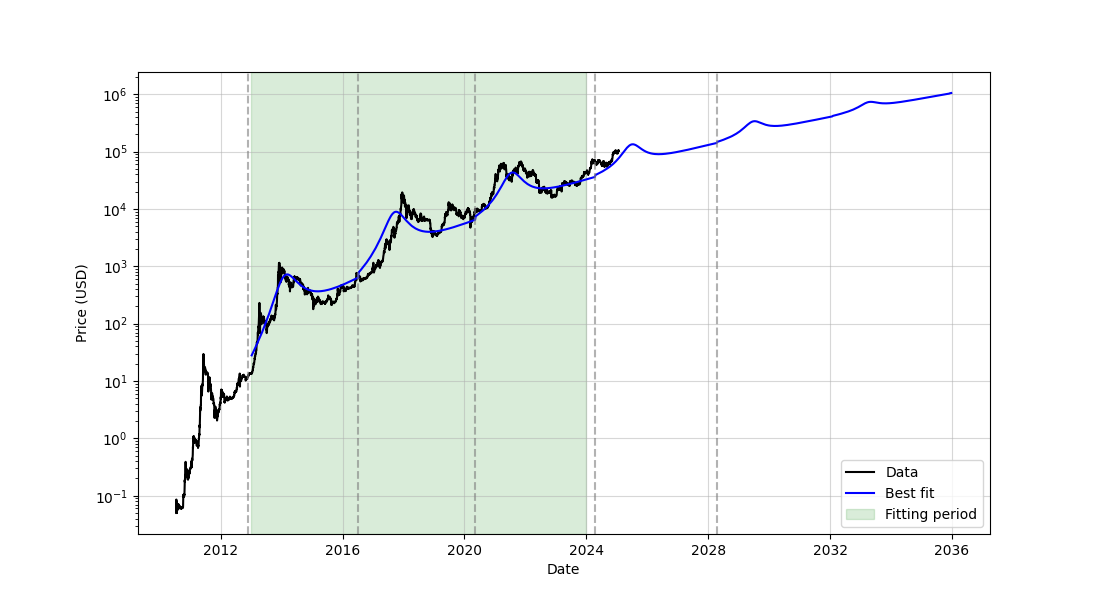

In [231]:

fig, ax=plt.subplots(figsize=(11,6))
ax.plot(btc_price.index, btc_price[yaxis], 'k', label='Data')
ax.plot(btc_predict.index, btc_predict['price_cycle'] ,'blue', label='Best fit')
for halving_date in btc_halving_dates: ax.axvline(np.datetime64(halving_date),color='grey',linestyle='--',alpha=.6)
ax.axvspan(start_cycle_fit, end_cycle_fit, color='green', alpha=.15, label='Fitting period')
ax.set_yscale('log')
ax.set_xlabel('Date');ax.set_ylabel('Price (USD)')
ax.legend();ax.grid(alpha=.5)
plt.show()

## time series

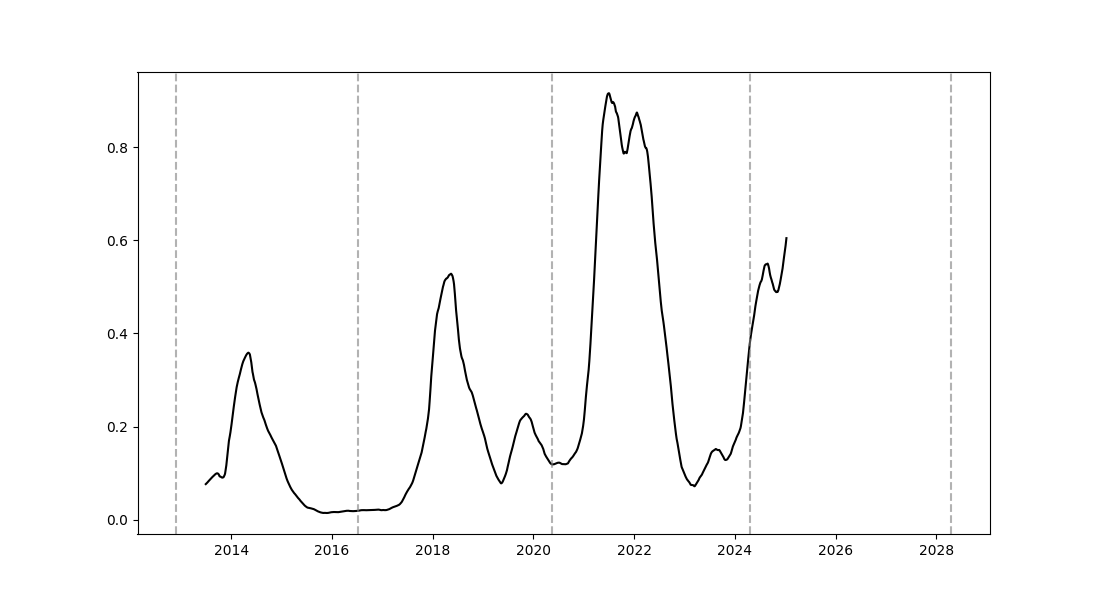

In [56]:
from scipy.signal import lombscargle
x, y = btc_cycle_fit['DAY_GEN'], btc_cycle_fit['cycle_ratio']
period_array = np.linspace(100,5*365,30)
freq_array = 1/period_array
power = lombscargle(x, y, freq_array, normalize=True, precenter=True)
fig, ax=plt.subplots(1,1)
ax.step(period_array, power)
ax.axvline(4*365,color='k',linestyle='--')

In [6]:
# support = np.exp(-41.5 + 6 * date )
def logdate_to_date(logdate):
    return genesis_block_date + np.timedelta64(1,'D')*np.exp(logdate)
curr_price = btc_price.iloc[-1].Close
curr_price_support_date = logdate_to_date((np.log(curr_price)+41.5)/6)
print('Current price is the Support of {} in {:}'.format(curr_price_support_date,curr_price_support_date-btc_price.index[-1]))
# = need to wait at most ... before profit

Current price is the Support of 2027-07-26 in 972 days 00:00:00


In [ ]:
# TO DO:
# cycle top simulated with lorentzian and 4 year period, with exp decay amplitude
# test with SplitLorentzianModel (asymetric lorentzian)
# use ML time serie with cycle ratio to predict future (similar to weather stuff)
# find support function by removing deviating data points iteratively (quantile regression)
# afficher achat perso
# ethereum

# open question:
# what is the exact shape of peaks/bullrun? can it be found with Fourier/Laplace transform?
# why was there 2 bullruns in 2020-2024? covid induced fiat inflation?
# is there a special "regime" that predicts bullrun cycle start? related to some potential/kinetic energy trade-off?
# when will PL end? what is "saturating" market cap? gold ($17T), some of real estate ($634T), USD in circulation ($2.3T), savings/pensions ($55T), etc...
# we know: price ~ network size ~ (nb users)^2 ~ (time^3)^2 ~ time^6 -> how infos spread in the market